# ADS 509 Final Team Project

### Jessica Hin, Halee Staggs, Vicky van der Wagt

----------------------------------------------------------------------------------

# Call Data from Clinicaltrial.gov API

In [264]:
# Import libraries
import requests
import json
import os
import datetime
import re
import time
import warnings

from bs4 import BeautifulSoup
from collections import defaultdict, Counter
import random
import shutil
import pandas as pd
import numpy as np
from tabulate import tabulate
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from string import punctuation
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from imblearn.metrics import specificity_score, sensitivity_score
import nltk
from nltk.classify import NaiveBayesClassifier
from sklearn.linear_model import LogisticRegression
from nltk.stem import WordNetLemmatizer
from collections import OrderedDict
# Download necessary NLTK data
#nltk.download('wordnet')
#nltk.download('omw-1.4')
#nltk.download('stopwords')


# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()


# Suppress FutureWarnings related to is_sparse
warnings.filterwarnings("ignore", category=FutureWarning, message="is_sparse is deprecated")

# Define figure parameters (feel free to change)
custom_palette = {'FEMALE': '#80ff80', 'MALE': '#99ccff'}
sns.set_style("darkgrid")
plt.rcParams.update({'axes.titlesize': 16,
                     'axes.labelsize': 14,
                     'xtick.labelsize': 12,
                     'ytick.labelsize': 12})

### Do a Test Call to API to check for bugs

In [2]:
# Define the base URL for the API
base_url = "https://clinicaltrials.gov/api/v2/studies"

# Define the query parameters and desired fields
params = {
    'format': 'json',
    'postFilter.overallStatus': 'COMPLETED',
    'postFilter.advanced': '(AREA[StudyType]INTERVENTIONAL OR OBSERVATIONAL) AND (AREA[Sex]MALE OR AREA[Sex]FEMALE)',
    'fields': 'NCTId|Condition|StartDate|PrimaryCompletionDate|BriefSummary|EnrollmentCount|Sex|MinimumAge|MaximumAge',
    'pageSize': 5  # Limit to 5 records for testing
}

# Function to make the API call
def fetch_clinical_trials(params):
    try:
        response = requests.get(base_url, params=params, headers={"accept": "application/json"})
        # Print the final URL to debug any issues with the query parameters
        print(f"Request URL: {response.url}")
        # Check if the request was successful
        if response.status_code == 200:
            return response.json()
        else:
            print(f"Failed to retrieve data: {response.status_code} - {response.text}")
            return None
    except requests.exceptions.RequestException as e:
        print(f"Request failed: {e}")
        return None

# Fetch the data and print it to test the connection
data = fetch_clinical_trials(params)

# Check if data was retrieved successfully
if data:
    # Print the JSON data
    print(json.dumps(data, indent=2))
else:
    print("No data retrieved or error occurred.")



Request URL: https://clinicaltrials.gov/api/v2/studies?format=json&postFilter.overallStatus=COMPLETED&postFilter.advanced=%28AREA%5BStudyType%5DINTERVENTIONAL+OR+OBSERVATIONAL%29+AND+%28AREA%5BSex%5DMALE+OR+AREA%5BSex%5DFEMALE%29&fields=NCTId%7CCondition%7CStartDate%7CPrimaryCompletionDate%7CBriefSummary%7CEnrollmentCount%7CSex%7CMinimumAge%7CMaximumAge&pageSize=5
{
  "studies": [
    {
      "protocolSection": {
        "identificationModule": {
          "nctId": "NCT01221623"
        },
        "statusModule": {
          "startDateStruct": {
            "date": "2010-10"
          },
          "primaryCompletionDateStruct": {
            "date": "2012-03"
          }
        },
        "descriptionModule": {
          "briefSummary": "This study is a Phase 3, double-blind, randomized, placebo-controlled study of the safety and efficacy of AA4500 0.58 mg in subjects with Peyronie's disease. Approximately 300 (200 AA4500 and 100 placebo) men will be randomized. Subjects will be scree

## Run full call to API

In [3]:
# Define the base URL for the API
base_url = "https://clinicaltrials.gov/api/v2/studies"

# Define the query parameters and desired fields
params = {
    'format': 'json',
    'postFilter.overallStatus': 'COMPLETED',
    'postFilter.advanced': '(AREA[StudyType]INTERVENTIONAL OR OBSERVATIONAL)',
    'fields': 'NCTId|Condition|StartDate|PrimaryCompletionDate|BriefSummary|EnrollmentCount|Sex|MinimumAge|MaximumAge',
    'pageSize': 1000  # Number of records to fetch per request
}

# Function to make the API call
def fetch_clinical_trials(params):
    try:
        response = requests.get(base_url, params=params, headers={"accept": "application/json"})
        # Print the final URL to debug any issues with the query parameters
        #print(f"Request URL: {response.url}")
        # Check if the request was successful
        if response.status_code == 200:
            print("API call successful")
            return response.json()
        else:
            print(f"Failed to retrieve data: {response.status_code} - {response.text}")
            return None
    except requests.exceptions.RequestException as e:
        print(f"Request failed: {e}")
        return None

# Function to extract relevant data from the API response
def extract_study_data(study):
    protocol_section = study.get('protocolSection', {})
    identification_module = protocol_section.get('identificationModule', {})
    status_module = protocol_section.get('statusModule', {})
    description_module = protocol_section.get('descriptionModule', {})
    conditions_module = protocol_section.get('conditionsModule', {})
    design_module = protocol_section.get('designModule', {})
    eligibility_module = protocol_section.get('eligibilityModule', {})

    # Exclude records where sex or brief summary is not available
    if 'sex' not in eligibility_module or 'briefSummary' not in description_module:
        return None

    return {
        'NCTId': identification_module.get('nctId', 'N/A'),
        'Condition': conditions_module.get('conditions', ['N/A']),
        'StartDate': status_module.get('startDateStruct', {}).get('date', 'N/A'),
        'PrimaryCompletionDate': status_module.get('primaryCompletionDateStruct', {}).get('date', 'N/A'),
        'BriefSummary': description_module.get('briefSummary', 'N/A'),
        'EnrollmentCount': design_module.get('enrollmentInfo', {}).get('count', 'N/A'),
        'Sex': eligibility_module.get('sex', 'N/A'),
        'MinimumAge': eligibility_module.get('minimumAge', 'N/A'),
        'MaximumAge': eligibility_module.get('maximumAge', 'N/A')
    }

# Fetch and process the data with a delay between requests and avoid duplicates
def fetch_and_process_data(params, max_requests):  # Increase max_requests for full data retrieval
    all_extracted_data = []
    seen_nct_ids = set()
    next_page_token = None

    for _ in range(max_requests):
        if next_page_token:
            params['pageToken'] = next_page_token

        data = fetch_clinical_trials(params)
        if data:
            studies = data.get('studies', [])
            next_page_token = data.get('nextPageToken', None)

            print(f"Number of studies fetched: {len(studies)}")  # Debugging statement
            for study in studies:
                nct_id = study.get('protocolSection', {}).get('identificationModule', {}).get('nctId')
                if nct_id and nct_id not in seen_nct_ids:
                    seen_nct_ids.add(nct_id)
                    extracted_data = extract_study_data(study)
                    all_extracted_data.append(extracted_data)
                    #print(json.dumps(extracted_data, indent=2))  # Debugging statement
                else:
                    print(f"Duplicate or missing NCTId: {nct_id}")

            if not next_page_token:
                break  # No more pages to fetch

        # Pause the execution for a short, random period of time to avoid overwhelming the server
        time.sleep(5 + 10 * random.random())
    
    return all_extracted_data

# Fetch data for random sample of MALE or FEMALE studies
random_sample_params = params.copy()
random_sample_params['postFilter.advanced'] += ' AND (AREA[Sex]MALE OR AREA[Sex]FEMALE)'
random_sample_studies = fetch_and_process_data(random_sample_params, max_requests=15)

# Combine both sets of data
all_data = random_sample_studies 

# Save the data to a file in repository to avoid sending request to server
with open('clinical_trials.json', 'w') as outfile:
    json.dump(all_data, outfile, indent=2)

print("Data fetching and processing complete.")

API call successful
Number of studies fetched: 1000
API call successful
Number of studies fetched: 1000
API call successful
Number of studies fetched: 1000
API call successful
Number of studies fetched: 1000
API call successful
Number of studies fetched: 1000
API call successful
Number of studies fetched: 1000
API call successful
Number of studies fetched: 1000
API call successful
Number of studies fetched: 1000
API call successful
Number of studies fetched: 1000
API call successful
Number of studies fetched: 1000
API call successful
Number of studies fetched: 1000
API call successful
Number of studies fetched: 1000
API call successful
Number of studies fetched: 1000
API call successful
Number of studies fetched: 1000
API call successful
Number of studies fetched: 1000
Data fetching and processing complete.


## Examine Data

In [68]:
# Convert the extracted data to a DataFrame
all_df = pd.DataFrame(all_data)
# Save DataFrame to a CSV file
all_df.to_csv('clinical_trials.csv', index=False)

NameError: name 'all_data' is not defined

# Start New File Here: EDA

### Read in .csv file of data 

In [121]:
all_df = pd.read_csv(r"clinical_trials.csv")

In [122]:
# Dataframe shape
all_df.shape

(15000, 9)

In [123]:
# Display the DataFrame
all_df.head(), all_df.tail()

(         NCTId               Condition   StartDate PrimaryCompletionDate  \
 0  NCT01221623  ["Peyronie's Disease"]     2010-10               2012-03   
 1  NCT02831023             ['Malaria']     2016-07               2017-01   
 2  NCT06322823                 ['IVF']  2020-01-01            2022-12-31   
 3  NCT01908023    ['Breast Neoplasms']     2013-05               2013-11   
 4  NCT01635023  ['Healthy Volunteers']     2012-07               2012-10   
 
                                         BriefSummary  EnrollmentCount     Sex  \
 0  This study is a Phase 3, double-blind, randomi...            418.0    MALE   
 1  The purpose of this study is to determine the ...             80.0    MALE   
 2  There are more than million frozen embryo tran...            116.0  FEMALE   
 3  Every year, almost 3000 Norwegian women are di...             15.0  FEMALE   
 4  Study in Healthy Males to Compare the White an...             27.0    MALE   
 
   MinimumAge MaximumAge  
 0   18 Years  

In [124]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   NCTId                  15000 non-null  object 
 1   Condition              15000 non-null  object 
 2   StartDate              14882 non-null  object 
 3   PrimaryCompletionDate  14343 non-null  object 
 4   BriefSummary           15000 non-null  object 
 5   EnrollmentCount        14797 non-null  float64
 6   Sex                    15000 non-null  object 
 7   MinimumAge             14178 non-null  object 
 8   MaximumAge             9919 non-null   object 
dtypes: float64(1), object(8)
memory usage: 1.0+ MB


# Preprocess All Data + EDA
    * Examine and handle missing values
    * Fix column datatypes
    * Feature creation

### Examine and Handle Missing Values

First handle missing values within the dataframe in preparation for plotting. 

In [125]:
# Count missing values (NaN) in each column
na_counts = all_df.isna().sum()
total_records = len(all_df)
percentage_na = (na_counts / total_records)

# Generate DataFrame from the counts and percentages
na_counts_df = pd.DataFrame({'Missing Count': na_counts, 'Missing Proportion': percentage_na})

# Reset index & rename the index column
na_counts_df.reset_index(inplace=True)
na_counts_df.rename(columns={'index': 'Column'}, inplace=True)

print("DataFrame with counts and percentages of missing (NaN) values:")
print(tabulate(na_counts_df, headers='keys', tablefmt='grid'))

DataFrame with counts and percentages of missing (NaN) values:
+----+-----------------------+-----------------+----------------------+
|    | Column                |   Missing Count |   Missing Proportion |
+====+=======================+=================+======================+
|  0 | NCTId                 |               0 |           0          |
+----+-----------------------+-----------------+----------------------+
|  1 | Condition             |               0 |           0          |
+----+-----------------------+-----------------+----------------------+
|  2 | StartDate             |             118 |           0.00786667 |
+----+-----------------------+-----------------+----------------------+
|  3 | PrimaryCompletionDate |             657 |           0.0438     |
+----+-----------------------+-----------------+----------------------+
|  4 | BriefSummary          |               0 |           0          |
+----+-----------------------+-----------------+----------------------+
|

A new df "no_nans" was created in order to do EDA - this is to seperate it from all the preprocessing step when splitting the data into train and test dataframes.

In [126]:
# Missing values to null for now (simplifies type conversions & plotting)
def na_to_null(df, column):
    """This function replaces "N/A" values in a df column with null"""
    df[column] = df[column].replace('N/A', np.nan)
    return df

no_nans = na_to_null(all_df, ['PrimaryCompletionDate', 'StartDate','EnrollmentCount','MinimumAge', 'MaximumAge'])

### Feature Clean-up, Feature Creation

New columns "MinimumAgeYrs" and "MaximumAgeYrs" are created to change all the values that are less than a year to 0.

In [127]:
# Extract years from age feature
def extract_years(age_feature):
    """This function converts age features to years. If the feature
    does not contain "Year" or "Years", needs to be 0 years. """
    # Check if the input value is already numeric
    if isinstance(age_feature, (int, float)):
        return age_feature
    # If not numeric, split text
    parts = age_feature.split()
    # If unit is Year or Years, return number before the unit
    if parts[1] == 'Years' or parts[1] == 'Year':
        return int(parts[0])
    # Else return 0 years (anything other than year is less than a year (weeks, months, etc))
    return 0

#convert age features to numerical
no_nans['MinimumAgeYrs'] = no_nans['MinimumAge'].apply(extract_years)
no_nans['MaximumAgeYrs'] = no_nans['MaximumAge'].apply(extract_years)

# Convert StartDate PrimaryCompletionDate column to date type
no_nans['StartDate'] = pd.to_datetime(no_nans['StartDate'], errors='coerce')
no_nans['PrimaryCompletionDate'] = pd.to_datetime(no_nans['PrimaryCompletionDate'], errors='coerce')

# Generate Year and Month columns 
no_nans['StartYear'] = no_nans['StartDate'].dt.year
no_nans['StartMonth'] = no_nans['StartDate'].dt.month
no_nans['StartDecade'] = (no_nans['StartYear'] // 10) * 10

# Generate Column for Number of Conditions
no_nans['ConditionCount'] = no_nans['Condition'].apply(lambda x: len(x.split(',')))

# Generate Column for study Duration
no_nans['Duration'] = (no_nans['PrimaryCompletionDate'] - no_nans['StartDate']).dt.days
no_nans['DurationYrsRounded'] = (no_nans['Duration'] / 365).round(2)


In [128]:
# Combine "condition" description with "brief summary" description
no_nans['all_text'] = no_nans['Condition']+" "+no_nans['BriefSummary']

In [129]:
no_nans['all_text'].head()

0    ["Peyronie's Disease"] This study is a Phase 3...
1    ['Malaria'] The purpose of this study is to de...
2    ['IVF'] There are more than million frozen emb...
3    ['Breast Neoplasms'] Every year, almost 3000 N...
4    ['Healthy Volunteers'] Study in Healthy Males ...
Name: all_text, dtype: object

# EDA of Data Other than Brief Summary

Let's first see how many different studies there are.

In [130]:
no_nans['Condition'].value_counts()

Condition
['Healthy']                                 846
['Breast Cancer']                           663
['Prostate Cancer']                         506
['Infertility']                             176
['Healthy Volunteers']                      158
                                           ... 
['Hysterosalpingography']                     1
['Anxiety', 'Sleep Disturbance']              1
['Healthy Volunteers - Haemophilia A']        1
['Catheter-related Bladder Discomfort']       1
['HIV-1-infection', 'Pregnancy Related']      1
Name: count, Length: 7464, dtype: int64

There are 7,417 different conditions that a person can possibly be in this dataframe. "Healthy" is amongst the most common conditions, we might need to consider only classifying for the top 5 conditions otherwise the counts are really low. 

In [131]:
# Gender stats
no_nans['Sex'].value_counts()

Sex
FEMALE    9656
MALE      5344
Name: count, dtype: int64

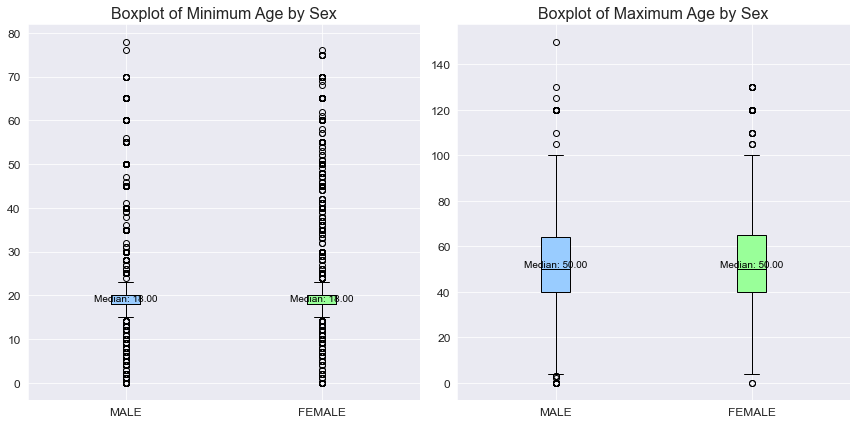

In [492]:
# Age stats by sex
import matplotlib.pyplot as plt

def plot_boxplot(data, column, ax, title, custom_palette):
    """Function to plot boxplots for a specific column, with annotations for male and female data"""
    # Filter data by sex
    data_male = data[data['Sex'] == 'MALE'][column].dropna()
    data_female = data[data['Sex'] == 'FEMALE'][column].dropna()
    
    # Plot boxplots
    male_boxes = ax.boxplot(data_male, positions=[1], patch_artist=True, medianprops=dict(color='black'), boxprops=dict(facecolor=custom_palette['MALE']))
    female_boxes = ax.boxplot(data_female, positions=[2], patch_artist=True, medianprops=dict(color='black'), boxprops=dict(facecolor=custom_palette['FEMALE']))
    
    # Add labels and title
    ax.set_title(title)
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['MALE', 'FEMALE'])
    
    # Annotate median values for male and female data
    male_median = male_boxes['medians'][0].get_ydata()[0]
    ax.annotate(f'Median: {male_median:.2f}', xy=(1, male_median), xytext=(1, male_median + 0.1), ha='center', va='bottom', fontsize=10, color='black')
    
    female_median = female_boxes['medians'][0].get_ydata()[0]
    ax.annotate(f'Median: {female_median:.2f}', xy=(2, female_median), xytext=(2, female_median + 0.1), ha='center', va='bottom', fontsize=10, color='black')

# Set up subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Define palette
custom_palette = {'FEMALE': '#99ff99', 'MALE': '#99ccff'} 

# Boxplot for MinimumAgeYrs
plot_boxplot(all_df, 'MinimumAgeYrs', axes[0], 'Boxplot of Minimum Age by Sex', custom_palette)

# Boxplot for MaximumAgeYrs
plot_boxplot(all_df, 'MaximumAgeYrs', axes[1], 'Boxplot of Maximum Age by Sex', custom_palette)

# Show plot
plt.tight_layout()
plt.show()



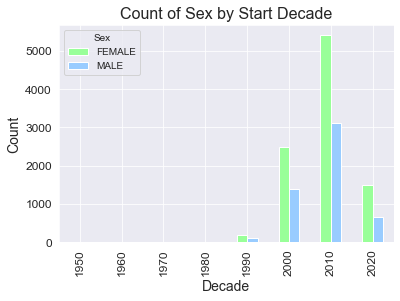

In [493]:
# Date stats by sex

#Could also do by year if desired
counts = no_nans.groupby(['StartDecade', 'Sex']).size().unstack(fill_value=0)

counts.index = counts.index.astype(int)

ax = counts.plot(kind='bar', stacked=False, color=custom_palette)

# Add labels and title
plt.title('Count of Sex by Start Decade')
plt.xlabel('Decade')
plt.ylabel('Count')
plt.legend(title='Sex')
 
# Show plot
plt.show()


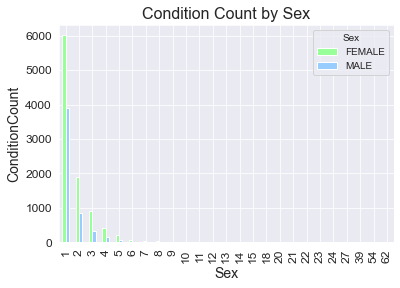

In [494]:
# Number of conditions by sex

counts = no_nans.groupby(['ConditionCount', 'Sex']).size().unstack(fill_value=0)

counts.index = counts.index.astype(int)

ax = counts.plot(kind='bar', stacked=False, color=custom_palette)

# Add labels and title
plt.title('Condition Count by Sex')
plt.xlabel('Sex')
plt.ylabel('ConditionCount')
 
# Show plot
plt.show()


In [495]:
# Enrollment Numbers by Sex

# Get descriptive statistics
enrollment_stats = no_nans.groupby('Sex')['EnrollmentCount'].describe()

# Round statistics to whole numbers
rounded_enrollment_stats = enrollment_stats.astype(int)

# Display table with title
print("Enrollment Statistics by Sex:\n")
print(tabulate(rounded_enrollment_stats, headers=rounded_enrollment_stats.columns, tablefmt='pretty'))

Enrollment Statistics by Sex:

+--------+-------+------+-------+-----+-----+-----+-----+--------+
|        | count | mean |  std  | min | 25% | 50% | 75% |  max   |
+--------+-------+------+-------+-----+-----+-----+-----+--------+
| FEMALE | 9535  | 691  | 10059 |  0  | 40  | 80  | 194 | 598682 |
|  MALE  | 5262  | 171  | 1983  |  0  | 18  | 34  | 71  | 114035 |
+--------+-------+------+-------+-----+-----+-----+-----+--------+


In [496]:
# Study Duration by Sex (rounded to closest # of years)

# Get descriptive statistics
duration_stats = no_nans.groupby('Sex')['DurationYrsRounded'].describe()

# Round statistics to whole numbers
rounded_duration_stats = round(duration_stats,2)

# Display table with title
print("Study Duration by Sex:\n")
print(tabulate(rounded_duration_stats, headers=rounded_duration_stats.columns, tablefmt='pretty'))

Study Duration by Sex:

+--------+--------+------+------+-----+------+------+------+-------+
|        | count  | mean | std  | min | 25%  | 50%  | 75%  |  max  |
+--------+--------+------+------+-----+------+------+------+-------+
| FEMALE | 9237.0 | 2.28 | 2.21 | 0.0 | 0.75 | 1.66 | 3.08 | 24.17 |
|  MALE  | 5087.0 | 1.63 | 2.29 | 0.0 | 0.25 | 0.82 | 2.17 | 46.95 |
+--------+--------+------+------+-----+------+------+------+-------+


## Train/Test Split

In [132]:
# Save SexString as a column for investigation/troubleshooting post-mapping
no_nans['SexString'] = no_nans['Sex']
no_nans['Sex'] = no_nans['Sex'].map({'FEMALE': 0, 'MALE': 1})


# Split the DataFrame into features (X) and target variable (y)
y = no_nans['Sex']
X = no_nans.drop(['Sex', 'SexString'],axis = 1)  # Drop target variable


# Split data into training and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In order to resample, I can't use smote as we hae non-numeric and categorical variables. But, we can manually do it. The X_train and y_train have to be put back together in order to resample.

In [133]:
# Create a synthetic DataFrame
y_train = pd.DataFrame(y_train)
y_train = y_train.rename(columns = {0:'Sex'})
temp_df = pd.concat([X_train, y_train], axis=1)

In [134]:
# Drop values of NaN for brieft summaries
temp_df = temp_df.dropna(subset=['BriefSummary'])

In [135]:
# Display class distribution
print("Original class distribution:")
print(temp_df['Sex'].value_counts())

Original class distribution:
Sex
0    7718
1    4282
Name: count, dtype: int64


## Oversampling method

In [501]:
# Now we move on to resampling
# Separate minority and majority classes

# Male =1, Female = 0
minority_class = temp_df[temp_df['Sex'] == 1]
majority_class = temp_df[temp_df['Sex'] == 0]

# Determine the number of samples in the majority class
majority_count = len(majority_class)

# Sample from the minority class with replacement to match the number of samples in the majority class
minority_resampled = minority_class.sample(n=majority_count, replace=True, random_state=42)

# Combine the resampled minority class with the original majority class
resampled_df = pd.concat([majority_class, minority_resampled])

# Shuffle the dataframe
resampled_df = resampled_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Display resampled class distribution
print("\nResampled class distribution:")
print(resampled_df['Sex'].value_counts())


Resampled class distribution:
1    7718
0    7718
Name: Sex, dtype: int64


## Undersampling method

In [136]:
# Separate minority and majority classes
minority_class = temp_df[temp_df['Sex'] == 1]
majority_class = temp_df[temp_df['Sex'] == 0]

# Determine the number of samples in the minority class
minority_count = len(minority_class)

# Sample from the majority class without replacement to match the number of samples in the minority class
majority_resampled = majority_class.sample(n=minority_count, replace=False, random_state=42)

# Combine the resampled majority class with the original minority class
resampled_df = pd.concat([minority_class, majority_resampled])

# Shuffle the dataframe
resampled_df = resampled_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Display resampled class distribution
print("\nResampled class distribution:")
print(resampled_df['Sex'].value_counts())


Resampled class distribution:
Sex
0    4282
1    4282
Name: count, dtype: int64


# Apply Preprocessing Steps to Brief Summary Text Data

In [381]:
sw = stopwords.words("english")
punctuation = set(punctuation)

# List of dimorphic body parts/experiences and medical/anatomical lemmas 
dimorphic_terms = [
    "Penis", "Scrotum", "Testicles","testicular", "Epididymis", "deferens", "Seminal vesicles",
    "Prostate", "prostatic", "Cowpers", "Foreskin",
    "Sperm", "Ejaculation", "Spermatogenesis",
    "Erection", "erectile", "Vagina", "vaginal", "Vulva", "Labia", "Clitoris",
    "clitoral", "ovarian", "uterine", "cervical", "menstrual", 
    "Vestibule", "Ovary", "Fallopian", "Uterus", "Cervix", "Bartholins",
    "Skenes", "Hymen", "Endometrium", "Myometrium", "Placenta",
    "Amniotic", "Umbilical", "Chorion", "Decidua", "Gestation",
    "Yolk", "Amnion", "Lochia", "Menstruation", "Period",
    "Menarche", "Menopause", "Ovulation", "Dysmenorrhea", "Labor", "Childbirth", "Lactation",
    "Breastfeeding", "Pregnancy", "pregnant", "male", "female", "man", "woman", "men", "women", "girl",
    "boy", "postmenopausal", "gestational", "polycystic", "contraception", "infant",
    "estradiol", "maternal", "placental", "body", "human", "cancer",
    "pcos", "endometriosis"
]

# List of common academic/medical noise terms that don't provide information
academic_stop_words = [
    "academic", "group", "study", "research", "blind", "recruit", "design",
    "healthy", "subjects", "participants", "purpose", "effects", "clinical",
    "trial", "single", "intervention", "disease", "patient", "day", "month",
    "year", "week", "determine", "test", "volunteer", "investigate", "investigator",
    "evaluate", "evaluated", "wa", "ha", "use", "difference", "demonstrate", "reliability",
    "usability", "compare", "contrast", "conducted", "aim", "may",
    "therapy", "treatment", "risk", "health", "efficacy", "effect",
    "rate", "level", "randomize", "randomized", "objective", "outcome",
    "primary", "secondary", "compared", "therapy", "treatment", "risk",
    "health", "evidence", "background", "with", "without", "adverse",
    "consequence", "consequences", "benefit", "form", "care", "using",
    "two", "subset", "similarity", "similarities", "similarly", "latter",
    "former", "use", "used", "concomitantly", "spontaneous", "responded",
    "attendance", "open", "label", "effectiveness", "effective", "whether",
    "state", "safety", "tolerability", "phase", "also", "time", "controlled",
    "also", "reusable", "overall", "new", "matching", "correlation", "plus",
    "addition", "characterize", "pilot", "behavior", "strong", "developed",
    "developing", "rationale", "indication", "indicated", "standard", 
    "standardized", "undergo", "screening", "represents", "screened",
    "represented", "representing", "tolerance", "people", "goal",
    "structured", "supervised", "placement", "control", "proven",
    "following", "followed", "designed", "describe", "described", 
    "implement", "implemented", "complete", "completed", "estimate",
    "estimated", "get", "comparative", "compared", "intervene", 
    "determined", "tested", "common", "assessed", "assess", "event",
    "find", "found", "first", "reducing", "openlabel", "marketed", 
    "asked", "take", "demonstrated", "conduct", "deliver", "delivered",
    "followup", "individualized", "individualised", "prospective",
    "currently", "current", "given", "experiment", "looking", "treated",
    "looked", "treat", "including", "investigated", "frequently", "frequent",
    "related", "relate", "interested", "taking", "conventional", "medical",
    "quality", "assessing", "pattern", "additional", "well", "multiple",
    "one", "life", "improve", "method", "increase", "symptom", "Do's",
    "administration", "different", "mg", "condition", "receive", "received",
    "result", "results", "reduce", "associated", "oral", "change", "changed",
    "placebo", "dose", "program", "drug", "among", "data", "hypothesis",
    "combination", "delivery", "however", "response", "high", "function",
    "administered", "type", "blood", "impact", "either", "factor",
    "undergoing", "crossover", "tablet", "disorder", "ii", "cell",
    "activity", "pharmacokinetic", "low", "measure", "based", "three",
    "four", "five", "six", "seven", "eight", "nine", "performance", 
    "performed", "pk", "main", "primary", "secondary", "efficient",
    "preferred", "examined", "examine", "prefer", "tends"
]

# Combine list
extra_sw = dimorphic_terms+academic_stop_words

# Lemmatize lists
extra_sw = [lemmatizer.lemmatize(term.lower()) for term in extra_sw]


# Combine NLTK stopwords with additional stopwords
final_stopwords = set(sw + extra_sw)

def remove_stopwords(tokens, sw):
    """This function removes stopwords (sw) from text"""
    return [token for token in tokens if token not in sw]

def tokenize(text):
    """This function splits text on whitespace."""
    return text.split()

def remove_punctuation(text, punct_set=punctuation):
    return "".join([ch for ch in text if ch not in punctuation])

def remove_dimorphic_terms(tokens, terms):
    """This function removes dimorphic terms from tokens."""
    return [token for token in tokens if token.lower() not in terms]

def lowercase_tokens(tokens):
    """This function converts all tokens to lowercase."""
    return [token.lower() for token in tokens]

def remove_numerical_tokens(tokens):
    """This function removes numerical tokens."""
    return [token for token in tokens if not token.isdigit()]

def lemmatize_tokens(tokens):
    """This function lemmatizes the tokens."""
    return [lemmatizer.lemmatize(token) for token in tokens]

def remove_duplicate_tokens(tokens):
    """This function removes duplicate tokens within a row's set of tokens while preserving order."""
    return list(OrderedDict.fromkeys(tokens))

def process_text(text, pipeline):
    if pd.isnull(text):  # Check if text is NaN
        return text  # Return NaN without processing
    else:
        for function in pipeline:
            text = function(text)
        return text

# Define the text processing pipeline
summary_pipeline = [
    remove_punctuation,
    tokenize,
    lowercase_tokens,
    remove_numerical_tokens,
    lemmatize_tokens,
    lambda tokens: remove_stopwords(tokens, final_stopwords),
    lambda tokens: remove_dimorphic_terms(tokens, extra_sw),
    remove_duplicate_tokens
]


In [382]:
# Save as new column, ProcessedSummmary for analysis
resampled_df['ProcessedSummary'] = resampled_df['all_text'].apply(lambda x: process_text(x, summary_pipeline))

In [294]:
resampled_df.shape, resampled_df['Sex'].value_counts()

((8564, 22),
 Sex
 0    4282
 1    4282
 Name: count, dtype: int64)

### Examine Clean Tokens

In [310]:
resampled_df['ProcessedSummary'].head(10)

0    [black, cohosh, extract, phytoestrogen, estrog...
1    [brownieforsymphony, pump, set, home, system, ...
2    [latent, tuberculosis, infection, vaccine, rut...
3    [dysfunction, dos, vardenafil, placebo, chines...
4    [major, obesity, development, nonalcoholic, fa...
5    [cancer, drug, chemotherapy, eflornithine, wor...
6    [capsiate, nonpungent, analogue, capsaicin, co...
7    [recurrent, urinary, tract, infection, rutis, ...
8    [steady, pharmacokinetics, desipramine, withwi...
9    [cancer, superiority, cabazitaxel, prednisone,...
Name: ProcessedSummary, dtype: object

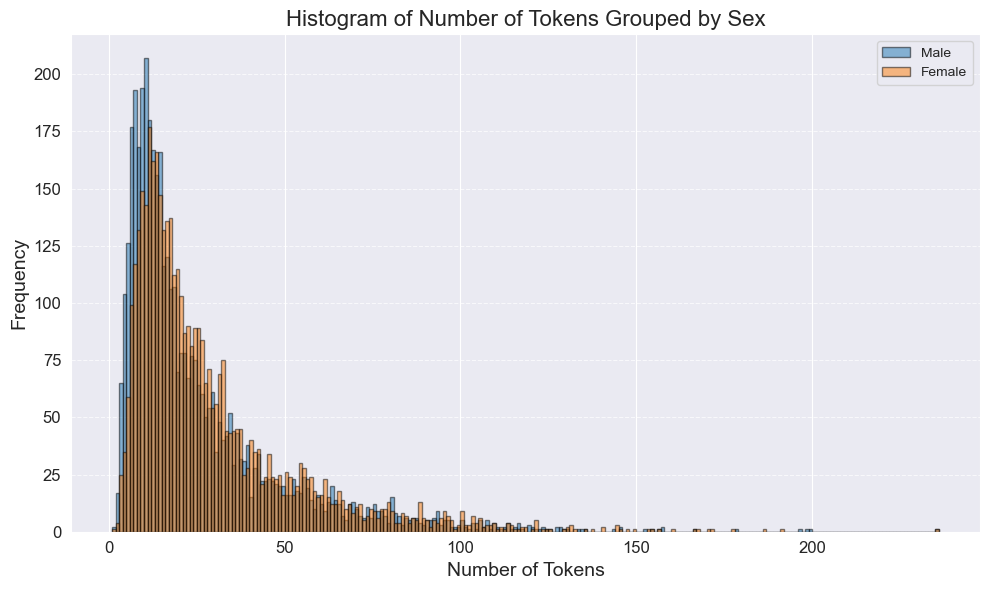

In [347]:
# Distribution of Number of Tokens by Sex
# Count the number of tokens in each list
# Function to count tokens in a list
def count_tokens(token_list):
    if isinstance(token_list, list):
        return len(token_list)
    else:
        return 0  
        
resampled_df['num_tokens'] = resampled_df['ProcessedSummary'].apply(count_tokens)

# Group by 'sex' and plot histogram
male_tokens = resampled_df[resampled_df['Sex'] == 1]['num_tokens']
female_tokens = resampled_df[resampled_df['Sex'] == 0]['num_tokens']

plt.figure(figsize=(10, 6))

plt.hist(male_tokens, bins=range(1, max(resampled_df['num_tokens']) + 2), alpha=0.5, label='Male', edgecolor='black')
plt.hist(female_tokens, bins=range(1, max(resampled_df['num_tokens']) + 2), alpha=0.5, label='Female', edgecolor='black')

plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.title('Histogram of Number of Tokens Grouped by Sex')
plt.legend(loc='upper right')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()

# Descriptive Stats of Text Data

In [89]:
# I had to rewrite the descriptive_stats function in order to read in the nested list of words.
def new_descriptive_stats(tokens, num_tokens = 5 , verbose=True) :

    # Fill in the correct values here. 
    flat_tokens = [token for sublist in tokens if isinstance(sublist, list) for token in sublist if not isinstance(token, float)]
    total_tokens = len(flat_tokens)  # total number of tokens
    num_tokens = len(flat_tokens) # number of tokens
    num_unique_tokens = len(set(flat_tokens)) # number of unique tokens
    lexical_diversity = num_unique_tokens/num_tokens  # lexical diversity
    num_characters = sum(len(token) for token in flat_tokens) # number of characters
    most_common_tokens = Counter(flat_tokens).most_common(num_tokens)[0:11] # most common tokens
   
    
    if verbose :        
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
        
    print(f"The ten most common tokens are {most_common_tokens} in the data.")      
    
    return([num_tokens, num_unique_tokens,
            lexical_diversity,
            num_characters])
    

## Female descriptives

In [383]:
new_descriptive_stats(resampled_df[resampled_df['Sex'] == 0]['ProcessedSummary'])

There are 122062 tokens in the data.
There are 18240 unique tokens in the data.
There are 946261 characters in the data.
The lexical diversity is 0.149 in the data.
The ten most common tokens are [('breast', 794), ('pain', 508), ('surgery', 335), ('physical', 263), ('exercise', 241), ('chemotherapy', 239), ('tumor', 235), ('postoperative', 223), ('complication', 221), ('infection', 216), ('age', 213)] in the data.


[122062, 18240, 0.1494322557388868, 946261]

## Male descriptives

In [384]:
new_descriptive_stats(resampled_df[resampled_df['Sex'] == 1]['ProcessedSummary'])

There are 107423 tokens in the data.
There are 18031 unique tokens in the data.
There are 836226 characters in the data.
The lexical diversity is 0.168 in the data.
The ten most common tokens are [('pharmacokinetics', 551), ('dos', 395), ('exercise', 295), ('muscle', 292), ('adult', 291), ('diabetes', 223), ('metabolism', 207), ('hormone', 205), ('physical', 205), ('pain', 191), ('training', 185)] in the data.


[107423, 18031, 0.16785046032972456, 836226]

# Word Clouds of Top Tokens for Male and Female

In [385]:
# Add Code

# Further processing of tokens for model-specific format

#### Preprocessing for SVM using tfidf

In [224]:
# Function to safely join tokens into a string
def safe_join(token_list):
    if isinstance(token_list, list):
        return ' '.join(token_list)
    return ''

In [350]:
# Convert lists of tokens into string vectors
resampled_df['vectors'] = resampled_df['ProcessedSummary'].apply(safe_join)

In [351]:
# Apply TfidfVectorizer
tfidf = TfidfVectorizer(max_df = 0.1)
resampled_tfidf = tfidf.fit_transform(resampled_df['vectors'])

In [352]:
# Print the resulting TF-IDF matrix
#print(resampled_tfidf.toarray()[0:2])
print(resampled_tfidf.data.nbytes)

1831768


In [353]:
#np.set_printoptions(threshold=np.inf)
#print(resampled_tfidf.toarray()[0])

In [354]:
resampled_tfidf.shape

(8564, 27927)

### Preprocessing for Naive Bayes 

In [359]:
# Function to get all tokens from the DataFrame
def get_all_tokens(df):
    return [token for sublist in df['ProcessedSummary'] for token in sublist]

# Get all tokens
all_tokens = get_all_tokens(resampled_df)

# Create frequency distribution for all tokens
word_dist = nltk.FreqDist(all_tokens)

# Define a word frequency cutoff
word_cutoff = 15  # Adjust this based on your data

# Collect words that appear at least word_cutoff times
feature_words = {word for word, count in word_dist.items() if count >= word_cutoff}

# Make into dataframe
feature_words_df = pd.DataFrame(list(feature_words), columns=['feature_word'])

# Look at top words
print("Top words:")
print(feature_words_df)

Top words:
     feature_word
0         fatigue
1        exposure
2        oxytocin
3          frozen
4       tolerable
...           ...
2743       pelvis
2744    efficient
2745    cognitive
2746      adjunct
2747      trigger

[2748 rows x 1 columns]


In [360]:
# Create function to identify if speeches contain the feature words identified above
def conv_features(text, fw) :
    # Initialize an empty dictionary to hold the feature words
    ret_dict = []
    
    # Iterate over the words in the list
    for word in text:
        # If the word is in the feature words set and not already in the dictionary
        if word in fw and word not in ret_dict:
            # Add the word to the dictionary with the value True
            ret_dict.append(word)
    return ret_dict

# Apply the function to the DataFrame
resampled_df['feature_words'] = resampled_df['ProcessedSummary'].apply(lambda x: conv_features(x, feature_words))

In [361]:
resampled_df['feature_words'].head()

0    [black, extract, estrogen, plant, origin, cont...
1    [pump, set, home, system, scale, score, proble...
2    [latent, infection, vaccine, adult, safe, dosa...
3    [dysfunction, dos, vardenafil, chinese, ed, ma...
4    [major, obesity, development, nonalcoholic, fa...
Name: feature_words, dtype: object

## Apply preprocessing steps to test set

In [362]:
# Convert lists of tokens into strings
X_test['ProcessedSummary'] = X_test['BriefSummary'].apply(lambda x: process_text(x, summary_pipeline))
X_test['vectors'] = X_test['ProcessedSummary'].apply(safe_join)
X_test_tfidf = tfidf.transform(X_test['vectors'])


# Model Training and Testing

## Preliminary SVM Model

In [363]:
svm_model = LinearSVC(random_state = 1, tol = 1e-5)
svm_model.fit(resampled_tfidf, resampled_df['Sex'])
y_pred_svm = svm_model.predict(X_test_tfidf)

svm_accuracy = accuracy_score(y_test, y_pred_svm)
svm_precision = precision_score(y_test, y_pred_svm)
svm_recall = recall_score(y_test, y_pred_svm)
svm_sensitivity =sensitivity_score(y_test, y_pred_svm)
svm_specificity = specificity_score(y_test, y_pred_svm)

evaluation_metrics = ['Accuracy', 'Precision', 'Recall', 'Sensitivity', 'Specificity']
svm_scores = [svm_accuracy, svm_precision, svm_recall, svm_sensitivity, svm_specificity]

svm_results_df = pd.DataFrame({
    'Evaluation Metric': evaluation_metrics,
    'SVM': svm_scores
})

#SVM Evaluation Metrics

print(tabulate(svm_results_df, headers='keys', tablefmt='grid'))


+----+---------------------+----------+
|    | Evaluation Metric   |      SVM |
+====+=====================+==========+
|  0 | Accuracy            | 0.847333 |
+----+---------------------+----------+
|  1 | Precision           | 0.73124  |
+----+---------------------+----------+
|  2 | Recall              | 0.899247 |
+----+---------------------+----------+
|  3 | Sensitivity         | 0.899247 |
+----+---------------------+----------+
|  4 | Specificity         | 0.818885 |
+----+---------------------+----------+


C:\Users\halee\anaconda3\lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


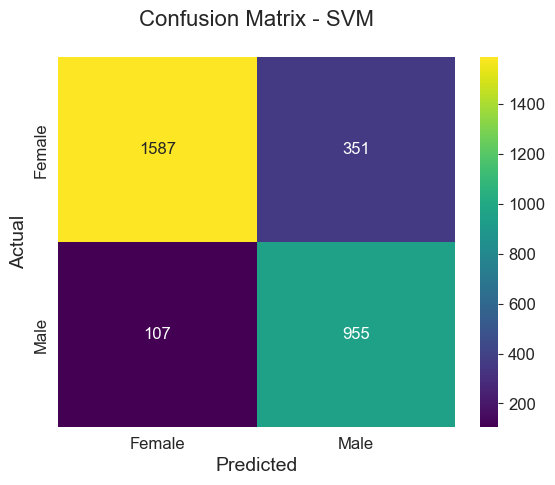

In [364]:
cm = confusion_matrix(y_test, y_pred_svm)
#sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=svm_model.classes_, yticklabels=svm_model.classes_)
sns.heatmap(cm, annot=True, cmap='viridis', fmt='g', xticklabels=['Female', 'Male'], 
            yticklabels=['Female', 'Male'], annot_kws={"size": 12})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - SVM\n')
plt.show()

In [365]:
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       0.94      0.82      0.87      1938
           1       0.73      0.90      0.81      1062

    accuracy                           0.85      3000
   macro avg       0.83      0.86      0.84      3000
weighted avg       0.86      0.85      0.85      3000



## Preliminary Naive Bayes Model

In [366]:
# Function to extract features from tokens
def extract_features(tokens):
    return {word: True for word in tokens}
    
# Prepare feature sets for training
feature_sets = [(extract_features(row['feature_words']), row['Sex']) for index, row in resampled_df.iterrows()]

# Train Naive Bayes classifier
classifier = NaiveBayesClassifier.train(feature_sets)

# Print the most informative features
classifier.show_most_informative_features(100)

Most Informative Features
              postpartum = True                0 : 1      =    142.3 : 1.0
                  mother = True                0 : 1      =    125.0 : 1.0
                     psa = True                1 : 0      =     71.0 : 1.0
                   fetal = True                0 : 1      =     69.7 : 1.0
                  breast = True                0 : 1      =     69.1 : 1.0
              peritoneal = True                0 : 1      =     56.3 : 1.0
              hemophilia = True                1 : 0      =     49.0 : 1.0
           contraceptive = True                0 : 1      =     45.4 : 1.0
                    pcos = True                0 : 1      =     41.0 : 1.0
            hypogonadism = True                1 : 0      =     38.3 : 1.0
                  labour = True                0 : 1      =     34.3 : 1.0
               antenatal = True                0 : 1      =     30.3 : 1.0
               dystrophy = True                1 : 0      =     29.0 : 1.0

## Apply preprocessing to test set and get predictions

In [367]:
# Prepare feature sets for testing
test_feature_sets = [extract_features(row['ProcessedSummary']) for index, row in X_test.iterrows()]

# Get predictions for each feature set
y_pred_nb = [classifier.classify(features) for features in test_feature_sets]

In [368]:
len(y_test), len(y_pred_nb)

(3000, 3000)

In [369]:
# Prepare lists to store probabilities and labels
probs = []
labels = []

# Classify and get probabilities for each entry
for i in test_feature_sets:
    prob_dist = classifier.prob_classify(i)
    estimated_sex = prob_dist.max()
    prob = prob_dist.prob(estimated_sex)
    probs.append(prob)
    labels.append(estimated_sex)

In [370]:
# Add probability metrics to dataframe
X_test['probs'] = probs
X_test['est_labels'] = labels

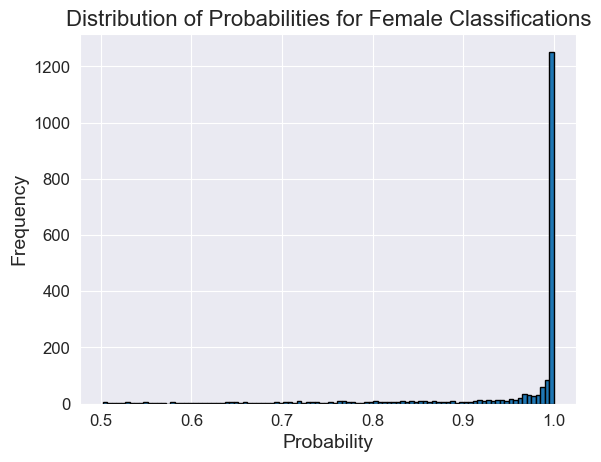

In [371]:
# Distribution of probabilities for Female
female_probs = X_test[X_test['est_labels'] == 0]['probs']

# Plot the histogram
plt.hist(female_probs, bins=100, edgecolor='black')
plt.title('Distribution of Probabilities for Female Classifications')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.show()

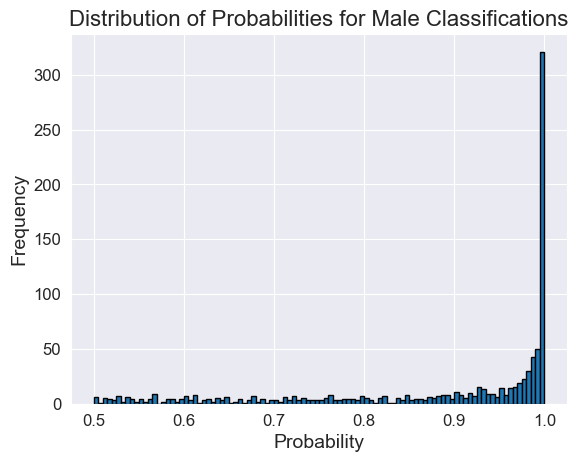

In [372]:
# Distributio of probabilities for Female
male_probs = X_test[X_test['est_labels'] == 1]['probs']

# Plot the histogram
plt.hist(male_probs, bins=100, edgecolor='black')
plt.title('Distribution of Probabilities for Male Classifications')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.show()

In [373]:
nb_accuracy = accuracy_score(y_test, y_pred_nb)
nb_precision = precision_score(y_test, y_pred_nb)
nb_recall = recall_score(y_test, y_pred_nb)
nb_sensitivity =sensitivity_score(y_test, y_pred_nb)
nb_specificity = specificity_score(y_test, y_pred_nb)

evaluation_metrics = ['Accuracy', 'Precision', 'Recall', 'Sensitivity', 'Specificity']
nb_scores = [nb_accuracy, nb_precision, nb_recall, nb_sensitivity, nb_specificity]

nb_results_df = pd.DataFrame({
    'Evaluation Metric': evaluation_metrics,
    'NB': nb_scores
})

#nb Evaluation Metrics

print(tabulate(nb_results_df, headers='keys', tablefmt='grid'))

+----+---------------------+----------+
|    | Evaluation Metric   |       NB |
+====+=====================+==========+
|  0 | Accuracy            | 0.842667 |
+----+---------------------+----------+
|  1 | Precision           | 0.811181 |
+----+---------------------+----------+
|  2 | Recall              | 0.724105 |
+----+---------------------+----------+
|  3 | Sensitivity         | 0.724105 |
+----+---------------------+----------+
|  4 | Specificity         | 0.907637 |
+----+---------------------+----------+


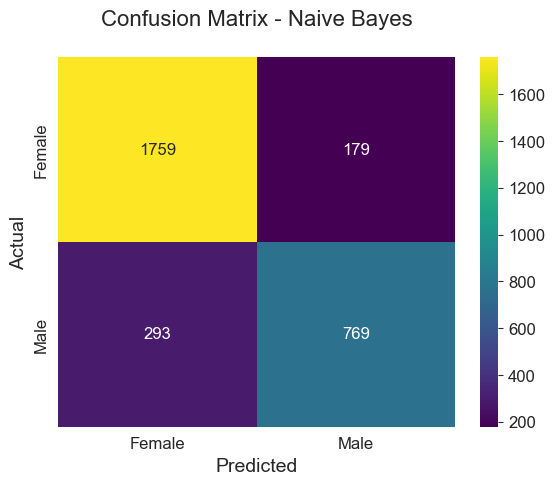

In [374]:
cm = confusion_matrix(y_test, y_pred_nb)
#sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=svm_model.classes_, yticklabels=svm_model.classes_)
sns.heatmap(cm, annot=True, cmap='viridis', fmt='g', xticklabels=['Female', 'Male'], 
            yticklabels=['Female', 'Male'], annot_kws={"size": 12})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Naive Bayes\n')
plt.show()



In [375]:
print(classification_report(y_test, y_pred_nb))

              precision    recall  f1-score   support

           0       0.86      0.91      0.88      1938
           1       0.81      0.72      0.77      1062

    accuracy                           0.84      3000
   macro avg       0.83      0.82      0.82      3000
weighted avg       0.84      0.84      0.84      3000



## Initial Logistic Regression Model

In [376]:
logreg = LogisticRegression(max_iter=100)
logreg.fit(resampled_tfidf, resampled_df['Sex'])
y_pred_logreg = logreg.predict(X_test_tfidf)


logreg_accuracy = accuracy_score(y_test, y_pred_logreg)
logreg_precision = precision_score(y_test, y_pred_logreg)
logreg_recall = recall_score(y_test, y_pred_logreg)
logreg_sensitivity =sensitivity_score(y_test, y_pred_logreg)
logreg_specificity = specificity_score(y_test, y_pred_logreg)

evaluation_metrics = ['Accuracy', 'Precision', 'Recall', 'Sensitivity', 'Specificity']
logreg_scores = [logreg_accuracy, logreg_precision, logreg_recall, logreg_sensitivity, logreg_specificity]

logreg_results_df = pd.DataFrame({
    'Evaluation Metric': evaluation_metrics,
    'logreg': logreg_scores
})

#logreg Evaluation Metrics

print(tabulate(logreg_results_df, headers='keys', tablefmt='grid'))

+----+---------------------+----------+
|    | Evaluation Metric   |   logreg |
+====+=====================+==========+
|  0 | Accuracy            | 0.847    |
+----+---------------------+----------+
|  1 | Precision           | 0.736842 |
+----+---------------------+----------+
|  2 | Recall              | 0.883239 |
+----+---------------------+----------+
|  3 | Sensitivity         | 0.883239 |
+----+---------------------+----------+
|  4 | Specificity         | 0.827141 |
+----+---------------------+----------+


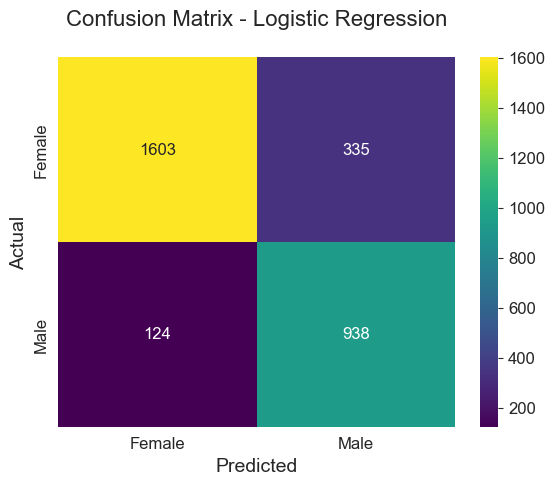

In [377]:
cm = confusion_matrix(y_test, y_pred_logreg)
#sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=svm_model.classes_, yticklabels=svm_model.classes_)
sns.heatmap(cm, annot=True, cmap='viridis', fmt='g', xticklabels=['Female', 'Male'], 
            yticklabels=['Female', 'Male'], annot_kws={"size": 12})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression\n')
plt.show()

In [378]:
print(classification_report(y_test, y_pred_logreg))

              precision    recall  f1-score   support

           0       0.93      0.83      0.87      1938
           1       0.74      0.88      0.80      1062

    accuracy                           0.85      3000
   macro avg       0.83      0.86      0.84      3000
weighted avg       0.86      0.85      0.85      3000



## Model Comparison

In [379]:
results_df = pd.DataFrame({
    'Evaluation Metric': ['Accuracy', 'Precision', 'Recall', 'Sensitivity', 'Specificity'],
    'SVM': [svm_accuracy, svm_precision, svm_recall, svm_sensitivity, svm_specificity],
    'NB': [nb_accuracy, nb_precision, nb_recall, nb_sensitivity, nb_specificity],
    'LogReg': [logreg_accuracy, logreg_precision, logreg_recall, logreg_sensitivity, logreg_specificity]
})

print(tabulate(results_df, headers='keys', tablefmt='grid'))


+----+---------------------+----------+----------+----------+
|    | Evaluation Metric   |      SVM |       NB |   LogReg |
+====+=====================+==========+==========+==========+
|  0 | Accuracy            | 0.847333 | 0.842667 | 0.847    |
+----+---------------------+----------+----------+----------+
|  1 | Precision           | 0.73124  | 0.811181 | 0.736842 |
+----+---------------------+----------+----------+----------+
|  2 | Recall              | 0.899247 | 0.724105 | 0.883239 |
+----+---------------------+----------+----------+----------+
|  3 | Sensitivity         | 0.899247 | 0.724105 | 0.883239 |
+----+---------------------+----------+----------+----------+
|  4 | Specificity         | 0.818885 | 0.907637 | 0.827141 |
+----+---------------------+----------+----------+----------+


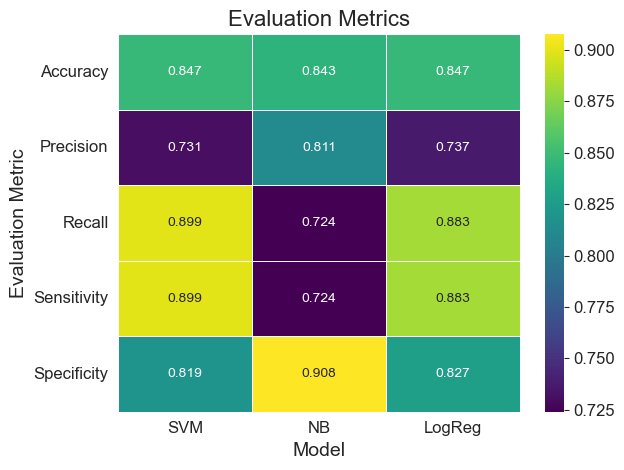

In [380]:
# Results Heatmap

sns.heatmap(results_df.set_index('Evaluation Metric'), annot=True, cmap='viridis', fmt=".3f", linewidths=.5)
plt.title('Evaluation Metrics')
plt.xlabel('Model')
plt.ylabel('Evaluation Metric')

plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
